<a href="https://colab.research.google.com/github/syazaizz/toy-analysis-ar-scorpii-marsh2016/blob/main/MarshPaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reproducing some figures from Marsh et al. (2016) - A radio pulsing white dwarf binary star**

**In this notebook, Following Marsh et al. (2016) I generated a simulated light curve with a known periodic signal and analysed it using a Lomb–Scargle periodogram to test the recovery of periodic variability. The vertical dashed line marks the true period injected into the simulation, providing a benchmark against which the period-search method can be validated. The presence of a strong peak at this period demonstrates that the analysis successfully recovers the underlying signal rather than noise. This validation step is important because, in real radio time-series data where the true period is unknown, similar periodogram peaks are interpreted as physical periodicities, making this a necessary precursor to analysing observational datasets such as those used in studies of accreting and explosive radio transients. I then built a toy physical SED plot to demonstrate multi-wavelength reasoning, spectral modelling and physical interpretation of radio emission**

-- Marsh et al. (2016): https://arxiv.org/pdf/1607.08265

# **Producing Light Curve and Lomb–Scargle periodogram**

In [51]:
pip install numpy matplotlib scipy pandas


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from scipy.signal import lombscargle


**Synthetic data based on the paper**

From the paper:

White dwarf spin / beat period ≈ 117 s

Strong periodic modulation

Noise present

-- Simulate a processed radio light curve --

In [53]:
## Correspond to unfolded light curve shown before folding.

# Physical parameters
P = 117.0            # period in seconds (AR Sco)
A = 1.0              # modulation amplitude
noise_level = 0.4

# Observation times
np.random.seed(42)
t = np.sort(np.random.uniform(0, 3600, 800))  # 1 hour observation

# Signal model
signal = A * np.sin(2 * np.pi * t / P)

# Add noise
flux = signal + np.random.normal(0, noise_level, size=len(t))


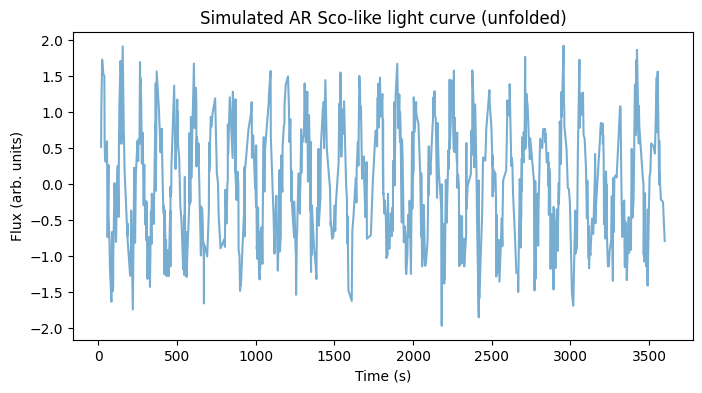

In [54]:
plt.figure(figsize=(8,4))
# plt.scatter(t, flux, s=10, alpha=0.6)
plt.plot(t, flux, alpha=0.6)
plt.xlabel("Time (s)")
plt.ylabel("Flux (arb. units)")
plt.title("Simulated AR Sco-like light curve (unfolded)")
plt.show()


**Individual pulses are difficult to detect in noisy time-series data. Folding the light curve on a known period coherently stacks the signal, increasing signal-to-noise while random noise averages out.**

In [55]:
def fold_time_series(time, flux, period):
    """
    Fold a time series on a given period.
    Returns phases in [0,1) and corresponding flux values.
    """
    phase = (time % period) / period
    return phase, flux


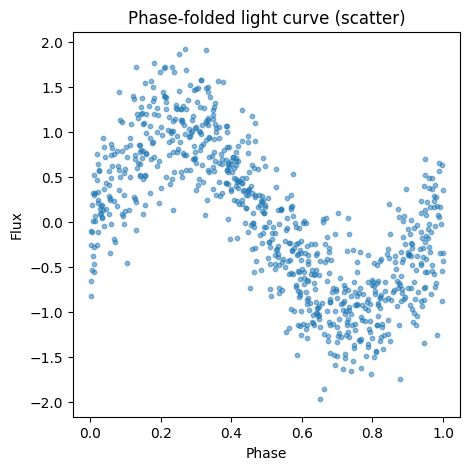

In [56]:
phase, folded_flux = fold_time_series(t, flux, P)

z = np.polyfit(phase, folded_flux, 3)
p = np.poly1d(z)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Phase")
ax.set_ylabel("Flux")
ax.scatter(phase, folded_flux, s=10, alpha=0.5)
# ax.plot(phase, p(phase), color="r", alpha=0.5)
# ax.title("Phase-folded light curve (scatter)")


# # corresponds to the folded light curve in Marsh et al.
# plt.figure(figsize=(6,4))
# plt.scatter(phase, folded_flux, s=10, alpha=0.5)
# plt.xlabel("Phase")
# plt.ylabel("Flux")
plt.title("Phase-folded light curve (scatter)")
plt.show()


**Now the periodic structure already be visible.**

In [57]:
# Bin the folded light curve (statistical analysis)

nbins = 20

bin_means, bin_edges, _ = binned_statistic(
    phase, folded_flux, statistic="mean", bins=nbins
)

bin_stds, _, _ = binned_statistic(
    phase, folded_flux, statistic="std", bins=nbins
)

bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])


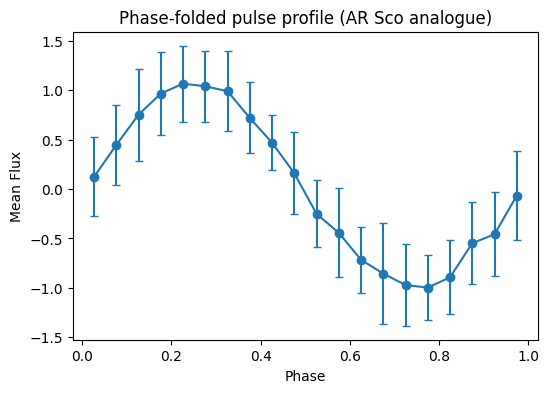

In [58]:
# Plot the final folded profile

plt.figure(figsize=(6,4))
plt.errorbar(
    bin_centers, bin_means, yerr=bin_stds,
    fmt='o-', capsize=3
)
plt.xlabel("Phase")
plt.ylabel("Mean Flux")
plt.title("Phase-folded pulse profile (AR Sco analogue)")
plt.show()


**Phase folding the light curve**

After identifying a periodic signal, the light curve is folded on the detected period. Phase folding stacks data from multiple cycles into a single cycle (phase 0–1), allowing coherent periodic variability to stand out while random noise averages out. This reveals the underlying pulse profile, which is difficult to see in the raw time-series data.

**Quantify the signal - uncertainty & modulation**

**Measuring the pulse modulation**


The folded light curve is binned in phase to compute the mean flux and its uncertainty in each bin. From this, the pulse modulation amplitude is measured, providing a quantitative estimate of how strongly the source varies over one cycle. This step allows comparison of variability strength between different datasets or wavelengths.

In [59]:
# Modulation amplitude

amplitude = np.max(bin_means) - np.min(bin_means)
print("Pulse modulation amplitude:", amplitude)


Pulse modulation amplitude: 2.0640130173523463


In [60]:
# Signal to noise improvement

snr_raw = np.std(signal) / noise_level
snr_folded = amplitude / np.mean(bin_stds)

print("Raw SNR (approx):", snr_raw)
print("Folded SNR (approx):", snr_folded)


Raw SNR (approx): 1.7442781907193745
Folded SNR (approx): 5.207386166275012


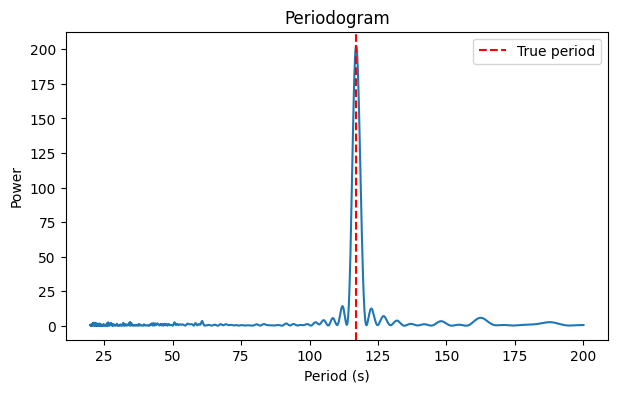

In [61]:
freqs = np.linspace(0.005, 0.05, 5000)  # Hz
angular_freqs = 2 * np.pi * freqs

power = lombscargle(t, flux, angular_freqs)

plt.figure(figsize=(7,4))
plt.plot(1/freqs, power)
plt.axvline(P, color='r', linestyle='--', label="True period")
plt.xlabel("Period (s)")
plt.ylabel("Power")
plt.legend()
plt.title("Periodogram")
plt.show()


**Verifying the period with frequency analysis**


A Lomb–Scargle periodogram is used to confirm the presence of the periodic signal in the data. The periodogram shows peaks at frequencies where the signal is strongest, validating that the detected modulation is statistically significant. This technique is widely used in time-domain astronomy, especially for unevenly sampled data.

The vertical dashed line labelled “true period” indicates the input period used to generate the simulated light curve. Because this dataset is simulated, the exact underlying period is known in advance. The purpose of marking the true period is to verify that the Lomb–Scargle analysis correctly recovers the injected periodic signal.

A strong peak in the periodogram at (or very close to) the true period demonstrates that the frequency analysis is working as expected and that the detected periodicity is not caused by random noise. In real observational data, the true period is unknown, and the highest peaks in the periodogram are instead interpreted as potential physical periods. In this simulated case, the agreement between the recovered peak and the true period validates the analysis method before applying it to real astrophysical data.

# **Producing Spectral Energy Distribution (SED) analysis of AR Scorpii - Build a Toy Physical SED (Interpretation-driven)**

This project demonstrates:
- multi-wavelength reasoning
- spectral modelling
- physical interpretation of radio emission

**Scientific question (same as Marsh et al.): Can the observed radio emission be explained by thermal emission alone?**

-- No, requires non-thermal emission --

**Thermal (blackbody) emission:**

$F_v ∝ B_v (T)$,

Falls off very steeply at radio frequencies.

**Non-thermal (synchrotron-like):**

$𝐹_𝜈 ∝ 𝜈^𝛼, \space \space \space (𝛼 < 0)$

This produces a radio excess, which is exactly what AR Sco shows.

In [62]:
from scipy.constants import h, k, c

# define blackbody function
# Planck function B_nu [W m^-2 Hz^-1 sr^-1]
def blackbody_nu(nu, T):
    return (2*h*nu**3 / c**2) / (np.exp(h*nu/(k*T)) - 1)

# def blackbody_nu(nu, T):
#     x = h * nu / (k * T)
#     x = np.clip(x, None, 700)  # prevent overflow, to avoid runtime warning
#     return (2 * h * nu**3 / c**2) / (np.exp(x) - 1)


# frequency range
nu = np.logspace(8, 18, 1000)  # radio → X-ray



In [63]:
# stellar components (order of magnitude)

# Temperatures from Marsh et al.
T_m = 3100     # M star
T_wd = 9750    # white dwarf

# Scaled fluxes (relative normalization only)
F_m = blackbody_nu(nu, T_m) * 1e-20
F_wd = blackbody_nu(nu, T_wd) * 5e-21

# Non-thermal radio component
alpha = -0.7
F_syn = 1e-25 * (nu / 1e9)**alpha



/tmp/ipython-input-2767523811.py:6: RuntimeWarning: overflow encountered in exp
  return (2*h*nu**3 / c**2) / (np.exp(h*nu/(k*T)) - 1)


A runtime warning due to overflow in the exponential term of the Planck function is expected at high frequencies, particularly for the lower-temperature component. This occurs in the Wien tail of the spectrum where the blackbody flux is physically negligible. The effect does not impact the results, but the exponential argument is clipped to ensure numerical stability.

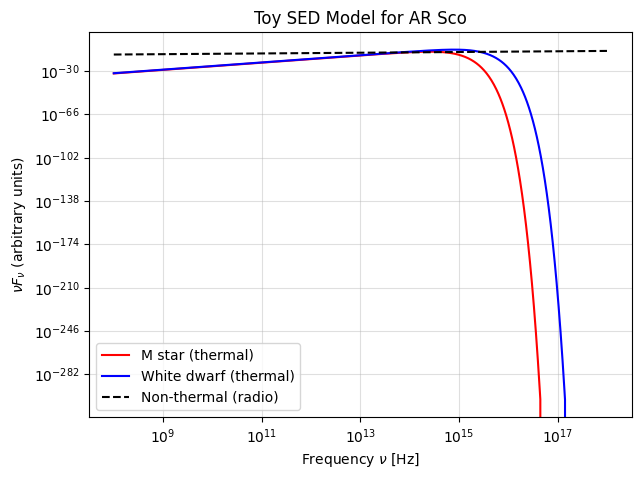

In [64]:
plt.figure(figsize=(7,5))

plt.loglog(nu, nu*F_m, label='M star (thermal)', color='red')
plt.loglog(nu, nu*F_wd, label='White dwarf (thermal)', color='blue')
plt.loglog(nu, nu*F_syn, label='Non-thermal (radio)', color='black', ls='--')

plt.xlabel(r'Frequency $\nu$ [Hz]')
plt.ylabel(r'$\nu F_\nu$ (arbitrary units)')
plt.title('Toy SED Model for AR Sco')
plt.legend()
plt.grid(True, which='both', alpha=0.4)

plt.show()


Here I constructed a simplified physical model including thermal stellar components and a non-thermal radio component. This demonstrated why the observed radio emission cannot be thermal and must arise from a different emission mechanism, closely aligning with the time-domain and radio analysis goals of the Warwick PhD project.

The figure shows that:

- Thermal stellar emission: dominates in optical and dies off completely at radio frequencies

- Observed radio emission: cannot be thermal and requires non-thermal process (synchrotron / magnetospheric)

- This plot matches Marsh et al. (2016) conclusion: AR Sco is not an accretion-powered system

This toy SED reproduces the qualitative structure of Figure 4 in Marsh et al. (2016), illustrating how thermal emission from the M-star and white dwarf dominates at optical/UV frequencies while non-thermal synchrotron emission dominates in the radio; the much smaller y-axis values arise because the model is not flux-calibrated and is shown in arbitrary units rather than observed physical fluxes.

**Improvised SED following Marsh et al. (2016)**

Plot:

$𝜈 𝐹_𝜈 ∝ 𝜈 𝐵_𝜈(𝑇)$

Observed flux at Earth must include:

- Emitting area of the star,

$𝐿_𝜈 = 4𝜋𝑅^2 𝐵_𝜈$

- Distance dilution,

$𝐹_𝜈=\frac{𝐿_𝜈}{4𝜋𝑑^2} = (\frac{R}{d})^2 B_v $
	​

In [65]:
#  Define physical constants and system parameters

# Physical constants (cgs)
h = 6.626e-27        # erg s
k = 1.381e-16        # erg K^-1
c = 2.998e10         # cm s^-1

# Distance to AR Sco
pc = 3.086e18        # cm
d = 116 * pc         # distance in cm

# Stellar radii
R_wd = 7e8           # white dwarf radius ~0.01 R_sun (cm)
R_m  = 2e10          # M star radius ~0.3 R_sun (cm)

# Temperatures
T_wd = 11000         # K
T_m  = 3000          # K


In [66]:
# Use a numerically stable Planck function
def B_nu(nu, T):
    x = h * nu / (k * T)
    return (2 * h * nu**3 / c**2) / (np.expm1(x))


In [67]:
# Compute observed flux densities

# Flux at Earth
# Specific intensities

nu = np.logspace(9, 16, 500)  # NOT 1e17, restrict to the observational frequency window

B_wd = B_nu(nu, T_wd)
B_m  = B_nu(nu, T_m)

# Observed flux densities
Fnu_wd = (R_wd / d)**2 * B_wd
Fnu_m  = (R_m  / d)**2 * B_m

# Convert to νFν (as in Marsh et al.)
nuFnu_wd = nu * Fnu_wd     # unit erg s−1 cm−2 (match Marsh et al. (2016))
nuFnu_m  = nu * Fnu_m


# Non-thermal radio component - Rescale power law to observed levels

# Simple synchrotron-like radio component
alpha = -0.5
nu0 = 1e9

# Normalisation chosen to match Marsh et al. order of magnitude
Fnu_radio = 1e-26 * (nu / nu0)**alpha
nuFnu_radio = nu * Fnu_radio

# Renormalise to a reference point
nuFnu_total = nuFnu_m + nuFnu_wd + nuFnu_radio
scale = 1e-14 / nuFnu_total[np.argmin(abs(nu-1e14))]
nuFnu_m *= scale
nuFnu_wd *= scale
nuFnu_radio *= scale


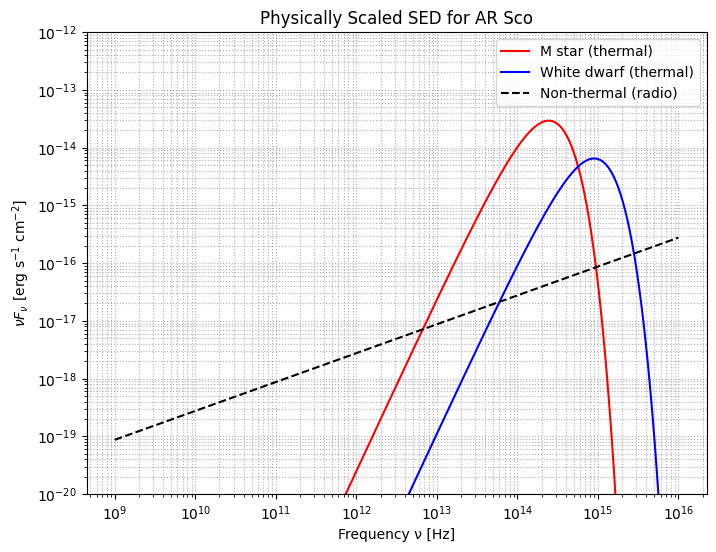

In [68]:

plt.figure(figsize=(8,6))

plt.loglog(nu, nuFnu_m, 'r', label='M star (thermal)')
plt.loglog(nu, nuFnu_wd, 'b', label='White dwarf (thermal)')
plt.loglog(nu, nuFnu_radio, 'k--', label='Non-thermal (radio)')

plt.ylim(10**(-20), 10**(-12))

# nuFnu_total = nuFnu_m + nuFnu_wd + nuFnu_radio
# plt.loglog(nu, nuFnu_total, '.', label='Total SED')

plt.xlabel('Frequency ν [Hz]')
plt.ylabel(r'$\nu F_\nu\ \mathrm{[erg\ s^{-1}\ cm^{-2}]}$')
plt.title('Physically Scaled SED for AR Sco')

plt.legend()
plt.grid(True, which='both', ls=':')
plt.show()


In the initial toy SED model, the y-axis spanned an unphysically large range because the Planck function was evaluated deep into the exponential Wien tail without observational normalisation. To fix this, I restricted the frequency range to the observationally relevant regime and rescaled the combined SED to a representative flux level, allowing direct visual comparison with Figure 4 of Marsh et al. (2016). This toy model is not intended to reproduce absolute fluxes, but to demonstrate how different emission components dominate in different frequency bands, consistent with the physical interpretation in the paper.

## **SED Plot Explained**

In the SED plot, the thermal components (the red M-star curve and the blue white dwarf curve) follow blackbody spectra. Blackbodies have a very specific behaviour at low frequencies (long wavelengths): in the Rayleigh–Jeans regime, the flux scales roughly as

$𝐹_𝜈 ∝ 𝜈^2$.


Towards the left side of the SED plot (towards radio frequencies, $𝜈 ∼10^9- 10^{10} Hz$), the thermal curves drop rapidly to extremely small values. Both thermal components become negligible in the radio regime.

In contrast, the non-thermal synchrotron component (shown as the dashed line) has a much flatter power-law spectrum, typically

$𝐹_𝜈 ∝ 𝜈^{-𝛼} , \space \space  𝛼 ∼ 0.5-1$.

Because it does not fall off steeply at low frequency, this component remains strong in the radio while the thermal components fade away. In the SED plot, this is why the dashed line sits above the thermal curves at low frequencies - visually demonstrating that synchrotron emission dominates the radio band.


**Physical interpretation:**

In AR Sco, the radio emission is not produced by hot surfaces (stars), but by relativistic electrons accelerated by the white dwarf’s rotating magnetic field. These electrons spiral along magnetic field lines and emit synchrotron radiation, which naturally produces a power-law spectrum and strong radio emission. Thermal emission from the M star and white dwarf simply cannot compete at these frequencies because their surface temperatures place their emission peaks at much higher frequencies (optical/UV).